In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from collections import OrderedDict

In [2]:
data = pd.read_csv('./data/stats.csv', header=None)
data.columns = ['job_id', 'name', 'job_type', 'job_index', 'status', 'date_started' ,'date_ended', 'total_minutes', 'total_seconds', 'feature_count', 'patient_count', 'luigi_workers', 'batch_size', 'memory_caching', 'precomputed_seg', 'reordered_nlpql', 'chained_queries', 'redis_cache']
data.head(n=20)

,job_id,name,job_type,job_index,status,date_started,date_ended,total_minutes,total_seconds,feature_count,patient_count,luigi_workers,batch_size,memory_caching,precomputed_seg,reordered_nlpql,chained_queries,redis_cache
0,800,SyntheticQuery_WithLimit_0,SyntheticQuery,0,COMPLETED,2018-12-06 22:16:28.117966,2018-12-06 22:16:52.854911,0,24.736945,603,179,4,25,False,False,False,False,False
1,801,SyntheticQuery_WithLimit_1,SyntheticQuery,1,COMPLETED,2018-12-06 22:17:58.271652,2018-12-06 22:20:33.815115,2,35.543463,0,0,4,25,False,False,False,False,False
2,802,SyntheticQuery_WithLimit_2,SyntheticQuery,2,COMPLETED,2018-12-06 22:20:28.842493,2018-12-06 22:25:10.206253,4,41.363760,362,112,4,25,False,False,False,False,False
3,803,SyntheticQuery_WithLimit_3,SyntheticQuery,3,COMPLETED,2018-12-06 22:26:00.185582,2018-12-06 22:32:04.123987,6,3.938405,215,100,4,25,False,False,False,False,False
4,804,SyntheticQuery_WithLimit_4,SyntheticQuery,4,COMPLETED,2018-12-06 22:26:31.613964,2018-12-06 22:30:26.063621,3,54.449657,309,112,4,25,False,False,False,False,False
5,805,SyntheticQuery_WithLimit_5,SyntheticQuery,5,COMPLETED,2018-12-06 22:31:03.680620,2018-12-06 22:42:18.019257,11,14.338637,416,95,4,25,False,False,False,False,False
6,806,SyntheticQuery_WithLimit_6,SyntheticQuery,6,COMPLETED,2018-12-06 22:31:35.003414,2018-12-06 22:35:23.289185,3,48.285771,268,86,4,25,False,False,False,False,False
7,807,SyntheticQuery_WithLimit_7,SyntheticQuery,7,COMPLETED,2018-12-06 22:41:08.139790,2018-12-06 22:47:44.553893,6,36.414103,362,112,4,25,False,False,False,False,False
8,808,SyntheticQuery_WithLimit_8,SyntheticQuery,8,COMPLETED,2018-12-06 22:41:39.941974,2018-12-06 22:50:08.327397,8,28.385423,633,198,4,25,False,False,False,False,False
9,809,SyntheticQuery_WithLimit_9,SyntheticQuery,9,COMPLETED,2018-12-06 22:50:11.859180,2018-12-06 22:50:32.909505,0,21.050325,362,112,4,25,False,False,False,False,False


In [3]:
baseline = data[data.job_id<=899][['job_index','feature_count', 'patient_count']]
baseline.columns = ['job_index', 'baseline_feature_count', 'baseline_patient_count']
baseline.head(n=25)

,job_index,baseline_feature_count,baseline_patient_count
0,0,603,179
1,1,0,0
2,2,362,112
3,3,215,100
4,4,309,112
5,5,416,95
6,6,268,86
7,7,362,112
8,8,633,198
9,9,362,112


In [4]:
evaluated = data[data.job_id>899]
evaluated['prop_name'] = evaluated[['luigi_workers', 'batch_size', 'memory_caching', 'precomputed_seg', 'reordered_nlpql', 'chained_queries', 'redis_cache']].astype(str).sum(axis=1)
evaluated = evaluated[['job_index', 'prop_name', 'feature_count', 'patient_count']]
evaluated.columns = ['job_index', 'prop_name', 'eval_feature_count', 'eval_patient_count']
evaluated.head()



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,job_index,prop_name,eval_feature_count,eval_patient_count
100,2,425FalseTrueFalseFalseFalse,362,112
101,3,425FalseTrueFalseFalseFalse,215,100
102,4,425FalseTrueFalseFalseFalse,309,112
103,5,425FalseTrueFalseFalseFalse,416,95
104,6,425FalseTrueFalseFalseFalse,268,86


In [5]:
merged = pd.merge(baseline, evaluated, how='left', on='job_index')
merged.loc[(merged['prop_name'] == '425TrueFalseFalseFalseFalse'),'prop_name'] = 'memory_caching'
merged.loc[(merged['prop_name'] == '425TrueFalseTrueFalseFalse'),'prop_name'] = 'memory_caching|reordered'
merged.loc[(merged['prop_name'] == '410FalseFalseFalseFalseFalse'),'prop_name'] = 'batch_size10'
merged.loc[(merged['prop_name'] == '4100FalseFalseFalseFalseFalse'),'prop_name'] = 'batch_size100'
merged.loc[(merged['prop_name'] == '425FalseFalseTrueFalseFalse'),'prop_name'] = 'reordered_nlpql'
merged.loc[(merged['prop_name'] == '425FalseTrueFalseFalseFalse'),'prop_name'] = 'precomputed_nlpql'
merged.loc[(merged['prop_name'] == '425FalseFalseFalseTrueFalse'),'prop_name'] = 'chained_queries'
merged.loc[(merged['prop_name'] == '425FalseFalseFalseFalseTrue'),'prop_name'] = 'redis_cache'
merged.loc[(merged['prop_name'] == '525FalseFalseFalseFalseFalse'),'prop_name'] = 'luigi_workers5'
merged.loc[(merged['prop_name'] == '425TrueTrueTrueFalseTrue'),'prop_name'] = 'all_but_chaining'
merged.loc[(merged['prop_name'] == '425TrueTrueTrueFalseFalse'),'prop_name'] = 'memory_caching|precomputed|reordered'
merged.loc[(merged['prop_name'] == '425FalseTrueTrueFalseTrue'),'prop_name'] = 'precomputed|reordered|redis'


merged['same_features'] = merged.apply (lambda row: row['baseline_feature_count']==row['eval_feature_count'],axis=1)
merged['same_patients'] = merged.apply (lambda row: row['baseline_patient_count']==row['eval_patient_count'],axis=1)
merged['same'] = merged.apply (lambda row: row['same_features'] and row['same_features']==row['same_patients'],axis=1)

merged

,job_index,baseline_feature_count,baseline_patient_count,prop_name,eval_feature_count,eval_patient_count,same_features,same_patients,same
0,0,603,179,memory_caching,603,179,True,True,True
1,0,603,179,memory_caching|reordered,603,179,True,True,True
2,0,603,179,batch_size10,545,163,False,False,False
3,0,603,179,reordered_nlpql,603,179,True,True,True
4,0,603,179,chained_queries,0,0,False,False,False
5,0,603,179,batch_size100,969,289,False,False,False
6,0,603,179,redis_cache,603,179,True,True,True
7,0,603,179,all_but_chaining,603,179,True,True,True
8,0,603,179,memory_caching|precomputed|reordered,603,179,True,True,True
9,0,603,179,precomputed|reordered|redis,603,179,True,True,True


In [6]:
less = merged[['job_index', 'prop_name', 'same']]
less

,job_index,prop_name,same
0,0,memory_caching,True
1,0,memory_caching|reordered,True
2,0,batch_size10,False
3,0,reordered_nlpql,True
4,0,chained_queries,False
5,0,batch_size100,False
6,0,redis_cache,True
7,0,all_but_chaining,True
8,0,memory_caching|precomputed|reordered,True
9,0,precomputed|reordered|redis,True


In [7]:
counts = less.groupby(["prop_name"], as_index=False).count()
counts = counts[['prop_name', 'same']]
counts.columns = ['prop_name', 'total']
counts['valid'] = 0
prop_names = ['luigi_workers5', 'chained_queries', 'precomputed_nlpql', 'reordered_nlpql', 'batch_size10', 'batch_size100', 'chained_queries', 'memory_caching', 'memory_caching|reordered_nlpql', 'redis_cache']
for i in prop_names:
    valid = less[(less.prop_name == i) & (less.same == True)].count()[0]
    counts.loc[(counts['prop_name'] == i),'valid']  = valid
counts['accuracy'] = counts.apply (lambda row: float(row['valid'])/float(row['total']),axis=1)
final = counts.loc[counts['prop_name'] != '425FalseFalseFalseFalseFalse'][['prop_name', 'accuracy']]
final = final.sort_values(by='accuracy', ascending=False)

counts

,prop_name,total,valid,accuracy
0,425FalseFalseFalseFalseFalse,6,0,0.000000
1,all_but_chaining,98,0,0.000000
2,batch_size10,100,0,0.000000
3,batch_size100,100,0,0.000000
4,chained_queries,100,69,0.690000
5,memory_caching,100,93,0.930000
6,memory_caching|precomputed|reordered,98,0,0.000000
7,memory_caching|reordered,100,0,0.000000
8,precomputed_nlpql,96,89,0.927083
9,precomputed|reordered|redis,15,0,0.000000


In [15]:
chart_final = final.pivot_table('accuracy', [], 'prop_name')
chart_final.values[0]
chart_final.columns
chart_final.sortlevel(["accuracy"], axis=1, ascending=False,  sort_remaining=True, inplace=True)

chart_final

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  after removing the cwd from sys.path.


prop_name,reordered_nlpql,redis_cache,precomputed|reordered|redis,precomputed_nlpql,memory_caching|reordered,memory_caching|precomputed|reordered,memory_caching,chained_queries,batch_size100,batch_size10,all_but_chaining
accuracy,0.93,0.939394,0.0,0.927083,0.0,0.0,0.93,0.69,0.0,0.0,0.0


In [9]:
chart = data
chart['prop_name'] = chart[['luigi_workers', 'batch_size', 'memory_caching', 'precomputed_seg', 'reordered_nlpql', 'chained_queries', 'redis_cache']].astype(str).sum(axis=1)
chart.loc[(chart['prop_name'] == '425TrueFalseFalseFalseFalse'),'prop_name'] = 'memory_caching'
chart.loc[(chart['prop_name'] == '425TrueFalseTrueFalseFalse'),'prop_name'] = 'memory_caching|reordered_nlpql'
chart.loc[(chart['prop_name'] == '410FalseFalseFalseFalseFalse'),'prop_name'] = 'batch_size10'
chart.loc[(chart['prop_name'] == '4100FalseFalseFalseFalseFalse'),'prop_name'] = 'batch_size100'
chart.loc[(chart['prop_name'] == '425FalseFalseTrueFalseFalse'),'prop_name'] = 'reordered_nlpql'
chart.loc[(chart['prop_name'] == '425FalseTrueFalseFalseFalse'),'prop_name'] = 'precomputed_nlpql'
chart.loc[(chart['prop_name'] == '425FalseFalseFalseTrueFalse'),'prop_name'] = 'chained_queries'
chart.loc[(chart['prop_name'] == '425FalseFalseFalseFalseTrue'),'prop_name'] = 'redis_cache'
chart.loc[(chart['prop_name'] == '425FalseFalseFalseFalseFalse'),'prop_name'] = 'baseline'
chart.loc[(chart['prop_name'] == '525FalseFalseFalseFalseFalse'),'prop_name'] = 'luigi_workers5'
chart.loc[(chart['prop_name'] == '425TrueTrueTrueFalseTrue'),'prop_name'] = 'all_opts'
chart.loc[(chart['prop_name'] == '425TrueTrueTrueFalseFalse'),'prop_name'] = 'memory_caching|precomputed|reordered_nlpql'
chart.loc[(chart['prop_name'] == '425FalseTrueTrueFalseTrue'),'prop_name'] = 'redis|precomputed|reordered_nlpql'
chart.loc[(chart['prop_name'] == '425FalseFalseTrueFalseTrue'),'prop_name'] = 'redis|reordered_nlpql'
chart = chart[chart.prop_name != 'chained_queries']

chart_data = chart[['job_index', 'prop_name', 'total_minutes']]
chart_data = chart_data.pivot_table('total_minutes', ['job_index'], 'prop_name')
chart_data.head()


prop_name,all_opts,baseline,batch_size10,batch_size100,memory_caching,memory_caching|precomputed|reordered_nlpql,memory_caching|reordered_nlpql,precomputed_nlpql,redis_cache,redis|precomputed|reordered_nlpql,reordered_nlpql
job_index,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,1.0,1.0,1.0,1.0,1.0,7.0,2.0,1.0,1.0
2,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,6.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0
4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Type: <class 'matplotlib.axes._subplots.AxesSubplot'>


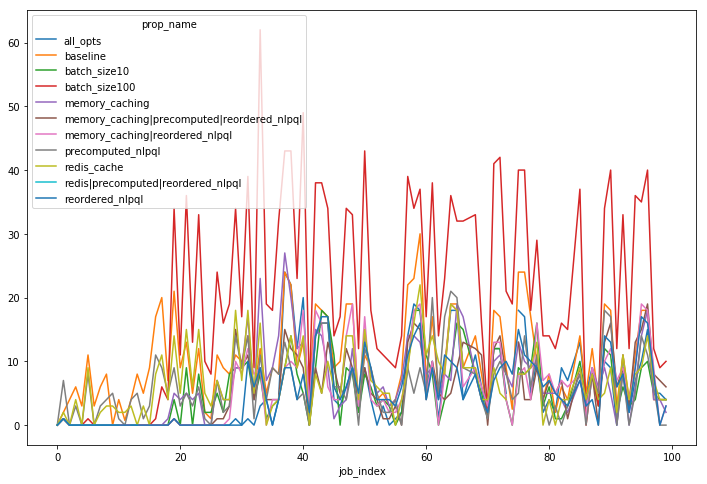

In [10]:
%matplotlib inline
graph = chart_data.plot(x = chart_data.index, y =chart_data.columns, figsize = (12,8))
print('Type:', type(graph))

In [11]:
import matplotlib.style as style
style.available

['tableau-colorblind10',
 'fivethirtyeight',
 'seaborn-darkgrid',
 'seaborn-whitegrid',
 'seaborn-colorblind',
 'Solarize_Light2',
 'seaborn-dark',
 'fast',
 'bmh',
 'seaborn-paper',
 'dark_background',
 'seaborn-dark-palette',
 'seaborn',
 'grayscale',
 'seaborn-pastel',
 'seaborn-bright',
 'seaborn-poster',
 'seaborn-white',
 'seaborn-muted',
 'ggplot',
 'seaborn-deep',
 'classic',
 'seaborn-ticks',
 'seaborn-talk',
 '_classic_test',
 'seaborn-notebook']

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(1,61,'Time by Job Index')

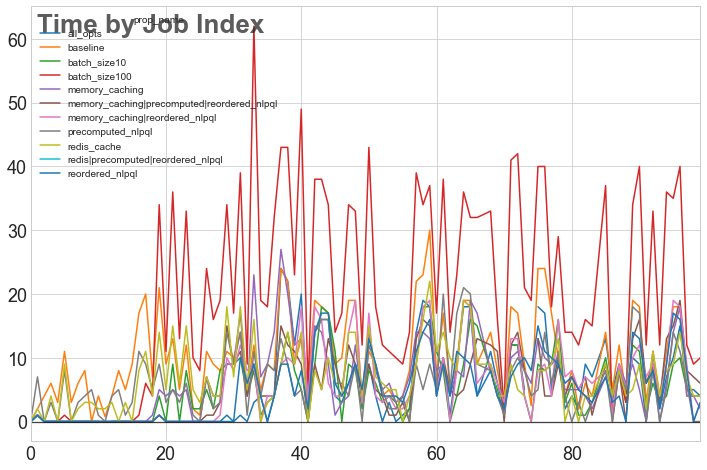

In [12]:
%matplotlib inline
style.use('seaborn-whitegrid')
graph = chart_data.plot(x = chart_data.index, y =chart_data.columns, figsize = (12,8))
graph.tick_params(axis = 'both', which = 'major', labelsize = 18)

# Generate a bolded horizontal line at y = 0 
graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
graph.xaxis.label.set_visible(False)
graph.set_xlim(left = 0, right = 99)

# Adding a title and a subtitle
graph.text(x = 1, y = 61, s = "Time by Job Index",
               fontsize = 26, weight = 'bold', alpha = .75)



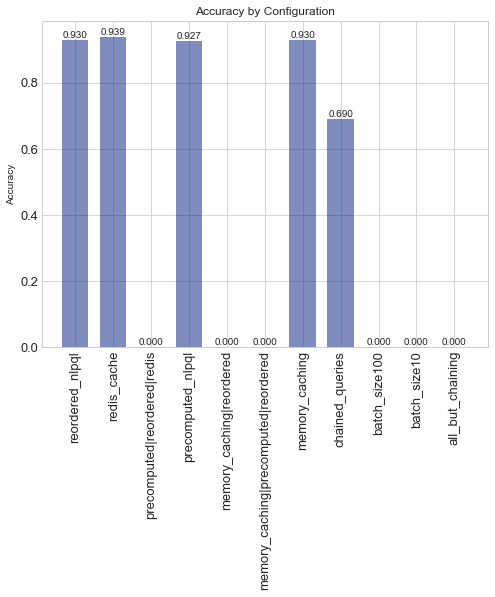

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
style.use('seaborn-dark-palette')


width = 0.7
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
y_pos = np.arange(len(chart_final.columns))
chart2 = plt.bar(y_pos, chart_final.values[0], width, alpha=0.5)
ax.tick_params(axis='x', rotation=90)

plt.xticks(y_pos, chart_final.columns)
plt.ylabel('Accuracy')
plt.title('Accuracy by Configuration')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                '%0.03f' % float(height),
                ha='center', va='bottom')

autolabel(chart2)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=14)